In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

In [16]:
base_dir = '/kaggle/input/egyptian-hieroglyphs/'

In [17]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # split 20% of the data for testing
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = len(train_generator.class_indices)

Found 3114 images belonging to 3 classes.
Found 776 images belonging to 3 classes.


In [67]:
def create_simple_cnn(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [68]:
def create_resnet(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_vgg16(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_inceptionv3(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_mobilenetv2(input_shape):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [69]:
def compile_and_train_model(model, train_gen, epochs=20, model_name='model'):
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 'Precision', 'Recall'])
    
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_accuracy', save_best_only=True)
    
    history = model.fit(train_gen, epochs=epochs, callbacks=[early_stopping, checkpoint])
    return history

In [70]:
def evaluate_model_train_test(model, train_gen, test_gen):
   
    train_metrics = model.evaluate(train_gen)
    y_train_pred = model.predict(train_gen)
    y_train_true = train_gen.classes
    y_train_pred_flat = np.argmax(y_train_pred, axis=1)
    train_report = classification_report(y_train_true, y_train_pred_flat, output_dict=True)

    
    test_metrics = model.evaluate(test_gen)
    y_test_pred = model.predict(test_gen)
    y_test_true = test_gen.classes
    y_test_pred_flat = np.argmax(y_test_pred, axis=1)
    test_report = classification_report(y_test_true, y_test_pred_flat, output_dict=True)

    
    return train_metrics[1], test_metrics[1], train_report, test_report

In [71]:
def extract_metrics(report):
    return {
        "Accuracy": report['accuracy'],
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-score": report['weighted avg']['f1-score']
    }

In [72]:
input_shape = (224, 224, 3)


models = {
    "VGG16": create_vgg16(input_shape),
    "ResNet50": create_resnet(input_shape),
    
    "InceptionV3": create_inceptionv3(input_shape),
    "MobileNetV2": create_mobilenetv2(input_shape),
    "Simple CNN": create_simple_cnn(input_shape)
}

results = []

for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = compile_and_train_model(model, train_generator, epochs=20, model_name=model_name)
    train_accuracy, test_accuracy, train_report, test_report = evaluate_model_train_test(model, train_generator, test_generator)
    
    metrics_train = extract_metrics(train_report)
    metrics_test = extract_metrics(test_report)

    results.append({
        "model": model_name,
        "Accuracy train": metrics_train['Accuracy'],
        "Accuracy test": metrics_test['Accuracy'],
        "Precision train": metrics_train['Precision'],
        "Precision test": metrics_test['Precision'],
        "Recall train": metrics_train['Recall'],
        "Recall test": metrics_test['Recall'],
        "F1-score train": metrics_train['F1-score'],
        "F1-score test": metrics_test['F1-score']
    })

Training VGG16...
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - Precision: 0.3665 - Recall: 0.2887 - accuracy: 0.3609 - loss: 1.6549
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: Precision,Recall,accuracy,loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - Precision: 0.5949 - Recall: 0.4748 - accuracy: 0.5676 - loss: 1.1211
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - Precision: 0.6337 - Recall: 0.5624 - accuracy: 0.6150 - loss: 1.0596
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - Precision: 0.6665 - Recall: 0.5987 - accuracy: 0.6452 - loss: 0.9714
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - Precision: 0.6882 - Recall: 0.6337 - accuracy: 0.6713 - loss: 0.9252
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - Precision: 0.6788 - Recall: 0.6394 - accuracy: 0.6681 - loss: 0.9270
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - Precision: 0.6857 - Recall: 0.6359 - accuracy: 0.6766 - loss: 0.8982
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - Precision: 0.6827 - Recall: 0.6549 - accuracy: 0.6771 - loss: 0.8715
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - Precision: 0.6779 - Recall: 0.6465 - accuracy: 0.6674 - loss: 0.8729
Epoch 10/20
98/98 ━

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 1/25 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 1.8192

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - Precision: 0.6675 - Recall: 0.6675 - accuracy: 0.6675 - loss: 0.8476
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
Training ResNet50...
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98/98 ━━━━━━━━━━━━━━━━━━━━ 87s 338ms/step - Precision: 0.4007 - Recall: 0.3051 - accuracy: 0.3899 - loss: 1.6518
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: Precision,Recall,accuracy,loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - Precision: 0.6270 - Recall: 0.4976 - accuracy: 0.5927 - loss: 1.0850
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - Precision: 0.6778 - Recall: 0.6027 - accuracy: 0.6567 - loss: 0.9609
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - Precision: 0.6989 - Recall: 0.6849 - accuracy: 0.6950 - loss: 0.9395
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - Precision: 0.6860 - Recall: 0.6591 - accuracy: 0.6800 - loss: 0.9578
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - Precision: 0.6901 - Recall: 0.6691 - accuracy: 0.6851 - loss: 0.9537
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - Precision: 0.6916 - Recall: 0.6871 - accuracy: 0.6907 - loss: 0.9129
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - Precision: 0.7016 - Recall: 0.6959 - accuracy: 0.7001 - loss: 0.8677
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - Precision: 0.7023 - Recall: 0.6992 - accuracy: 0.7003 - loss: 0.8672
Epoch 10/20
98/98 ━

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - Precision: 0.6675 - Recall: 0.6675 - accuracy: 0.6675 - loss: 1.2707
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step
Training InceptionV3...


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 124s 482ms/step - Precision: 0.3960 - Recall: 0.3226 - accuracy: 0.3931 - loss: 1.7097
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: Precision,Recall,accuracy,loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - Precision: 0.6404 - Recall: 0.5246 - accuracy: 0.6288 - loss: 1.0335
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - Precision: 0.6971 - Recall: 0.6756 - accuracy: 0.6947 - loss: 0.9535
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - Precision: 0.7093 - Recall: 0.7042 - accuracy: 0.7082 - loss: 0.8940
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - Precision: 0.6942 - Recall: 0.6928 - accuracy: 0.6940 - loss: 0.9080
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - Precision: 0.7055 - Recall: 0.7020 - accuracy: 0.7033 - loss: 0.8513
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - Precision: 0.6930 - Recall: 0.6923 - accuracy: 0.6930 - loss: 0.9061
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - Precision: 0.6882 - Recall: 0.6877 - accuracy: 0.6877 - loss: 0.8859
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - Precision: 0.6888 - Recall: 0.6880 - accuracy: 0.6888 - loss: 0.8759
Epoch 10/20
98/98 ━

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - Precision: 0.6675 - Recall: 0.6675 - accuracy: 0.6675 - loss: 15.6586
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step
Training MobileNetV2...
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 291ms/step - Precision: 0.3831 - Recall: 0.3247 - accuracy: 0.3767 - loss: 1.6704
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: Precision,Recall,accuracy,loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - Precision: 0.6081 - Recall: 0.5140 - accuracy: 0.5796 - loss: 1.0805
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - Precision: 0.6555 - Recall: 0.5693 - accuracy: 0.6357 - loss: 0.9526
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - Precision: 0.6793 - Recall: 0.6159 - accuracy: 0.6626 - loss: 0.9814
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - Precision: 0.6850 - Recall: 0.6358 - accuracy: 0.6709 - loss: 0.9153
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - Precision: 0.6773 - Recall: 0.6329 - accuracy: 0.6724 - loss: 0.9041
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - Precision: 0.6944 - Recall: 0.6612 - accuracy: 0.6879 - loss: 0.8899
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - Precision: 0.6809 - Recall: 0.6365 - accuracy: 0.6669 - loss: 0.8881
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - Precision: 0.6934 - Recall: 0.6610 - accuracy: 0.6916 - loss: 0.8731
Epoch 10/20
98/98 ━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - Precision: 0.6675 - Recall: 0.6675 - accuracy: 0.6675 - loss: 1.4767
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step
Training Simple CNN...
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - Precision: 0.4140 - Recall: 0.3551 - accuracy: 0.4098 - loss: 1.7702
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: Precision,Recall,accuracy,loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - Precision: 0.5776 - Recall: 0.4712 - accuracy: 0.5335 - loss: 1.1018
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - Precision: 0.6494 - Recall: 0.5546 - accuracy: 0.6198 - loss: 0.9770
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - Precision: 0.6888 - Recall: 0.6056 - accuracy: 0.6531 - loss: 0.8626
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - Precision: 0.7214 - Recall: 0.6402 - accuracy: 0.6962 - loss: 0.8131
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - Precision: 0.7410 - Recall: 0.6681 - accuracy: 0.7126 - loss: 0.7136
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - Precision: 0.7710 - Recall: 0.6969 - accuracy: 0.7430 - loss: 0.6229
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - Precision: 0.8034 - Recall: 0.7415 - accuracy: 0.7756 - loss: 0.5426
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - Precision: 0.8225 - Recall: 0.7680 - accuracy: 0.7938 - loss: 0.4878
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - Precision: 0.0373 - Recall: 0.0373 - accuracy: 0.0373 - loss: 46.0015    
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
results_df = pd.DataFrame(results)
results_df

,model,Accuracy train,Accuracy test,Precision train,Precision test,Recall train,Recall test,F1-score train,F1-score test
0,VGG16,0.699743,0.701031,0.489640,0.491444,0.699743,0.701031,0.576135,0.577819
1,ResNet50,0.699743,0.701031,0.489640,0.491444,0.699743,0.701031,0.576135,0.577819
2,InceptionV3,0.699743,0.701031,0.489640,0.491444,0.699743,0.701031,0.576135,0.577819
3,MobileNetV2,0.699743,0.701031,0.489640,0.491444,0.699743,0.701031,0.576135,0.577819
4,Simple CNN,0.200064,0.199742,0.040039,0.039897,0.200064,0.199742,0.066724,0.066509


In [83]:
def plot_results(results):
    results_df = pd.DataFrame(results)

    
    bar_width = 0.2
    x = np.arange(len(results_df['model']))

    
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))

    
    ax[0].bar(x - bar_width, results_df['Accuracy train'], width=bar_width, label='Train Accuracy')
    ax[0].bar(x, results_df['Accuracy test'], width=bar_width, label='Test Accuracy')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(results_df['model'])
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Model Accuracy Comparison')
    ax[0].legend()

    
    ax[1].bar(x - bar_width, results_df['F1-score train'], width=bar_width, label='Train F1-Score')
    ax[1].bar(x, results_df['F1-score test'], width=bar_width, label='Test F1-Score')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(results_df['model'])
    ax[1].set_ylabel('F1-Score')
    ax[1].set_title('Model F1-Score Comparison')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

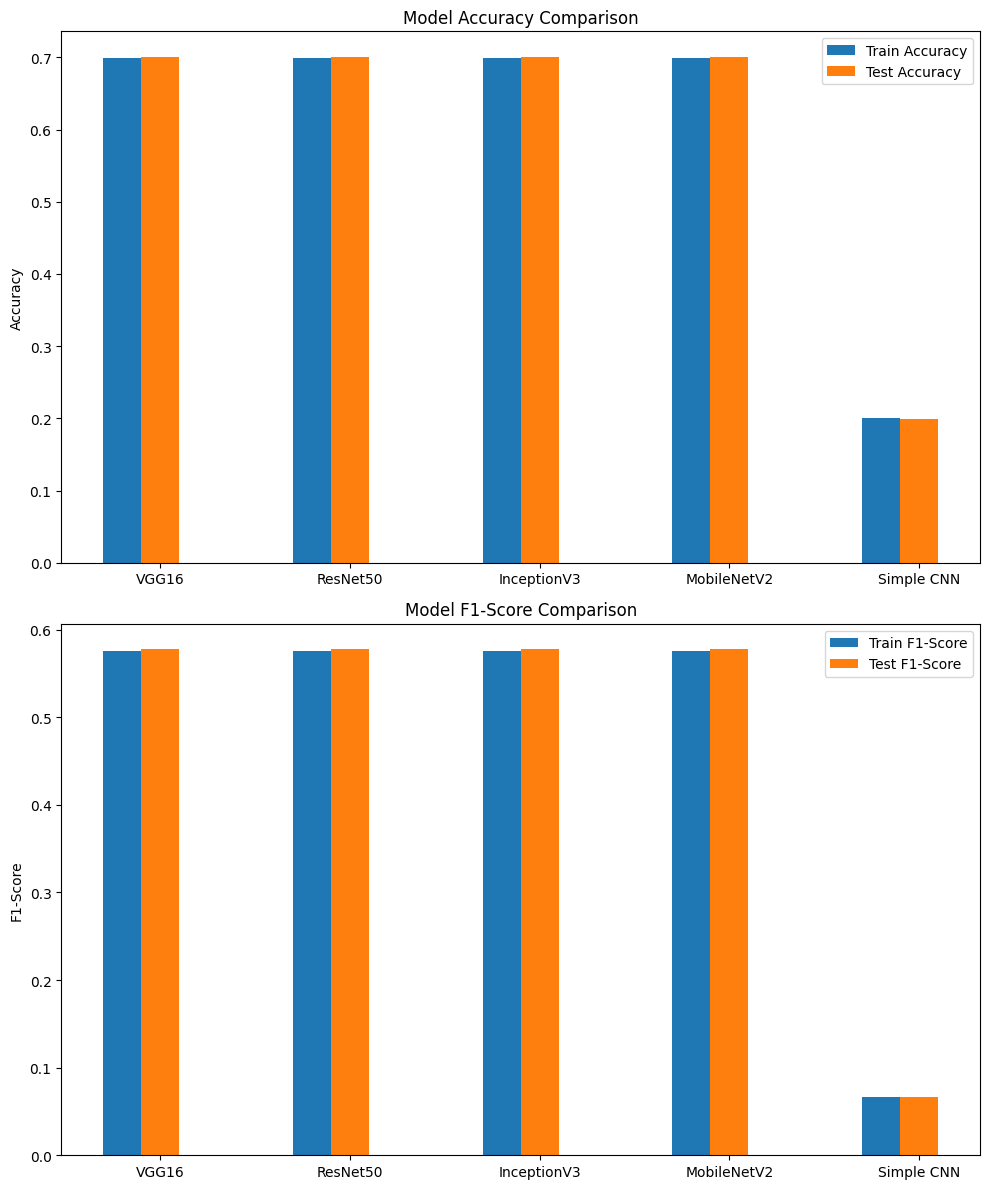

In [84]:
plot_results(results)

In [86]:
input_shape = (224, 224, 3)
simple_cnn_model = create_simple_cnn(input_shape)
simple_cnn_history = compile_and_train_model(simple_cnn_model, train_generator, epochs=15, model_name='simple_cnn_model')


train_accuracy_cnn, test_accuracy_cnn, train_report_cnn, test_report_cnn = evaluate_model_train_test(simple_cnn_model, train_generator, test_generator)



Epoch 1/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - Precision: 0.3813 - Recall: 0.3275 - accuracy: 0.3789 - loss: 1.9539
Epoch 2/15


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: Precision,Recall,accuracy,loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - Precision: 0.5686 - Recall: 0.4715 - accuracy: 0.5405 - loss: 1.1228
Epoch 3/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - Precision: 0.6211 - Recall: 0.5315 - accuracy: 0.5941 - loss: 1.0068
Epoch 4/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - Precision: 0.6871 - Recall: 0.5978 - accuracy: 0.6485 - loss: 0.8506
Epoch 5/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - Precision: 0.6988 - Recall: 0.6232 - accuracy: 0.6752 - loss: 0.8151
Epoch 6/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - Precision: 0.7215 - Recall: 0.6427 - accuracy: 0.6932 - loss: 0.7696
Epoch 7/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - Precision: 0.7510 - Recall: 0.6662 - accuracy: 0.7224 - loss: 0.6944
Epoch 8/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - Precision: 0.7652 - Recall: 0.6847 - accuracy: 0.7368 - loss: 0.6542
Epoch 9/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - Precision: 0.7951 - Recall: 0.7296 - accuracy: 0.7764 - loss: 0.5912
Epoch 10/15
98/98 ━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - Precision: 0.5305 - Recall: 0.5305 - accuracy: 0.5305 - loss: 1.5942
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label=f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label=f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

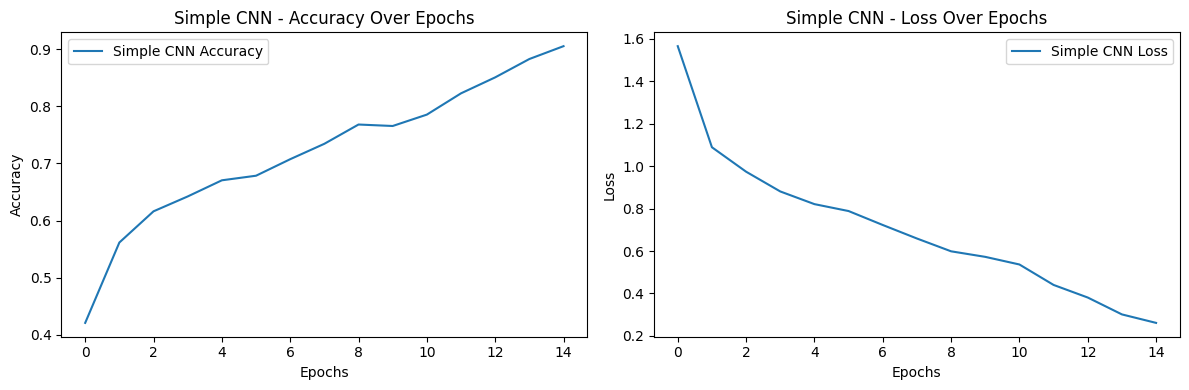

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
plot_training_history(simple_cnn_history, "Simple CNN")
